# Sales ratio study with real data

AssessPy can easily be used with various data to conduct a sales ratio study. In this vignette, we demonstrate this process using real data from the Cook County Assessor's Office (CCAO). The CCAO publishes assessments and sales on the [Cook County Open Data Portal](https://datacatalog.cookcountyil.gov/stories/s/i22y-9sd2).

## Basics of sales ratio studies

A sales ratio is the ratio of the assessor's estimate of a property's value to the sale price of a property. A sales ratio study is a report on how accurately and fairly an assessor predicted property values. The CCAO has a [rigorous set of rules](https://gitlab.com/groups/ccao-data-science---modeling/-/wikis/SOPs/Sales%20Ratio%20Studies) that govern how sales ratios studies are conducted.

In general, there are four important statistics produced in sales ratio studies, listed in the table below. It is important to understand that these statistics are calculated based on properties that sell. In most jurisdictions, the number of properties that sell in any single year is a very small percentage of the overall number of properties. In order to characterize the quality of the assessment role in a jurisdiction, we draw an inference from this small number of properties.

| Statistic               | Acceptable Range | Interpretation                                                                                                                                                                             |
|------------------------|------------------------|------------------------|
| COD                     | 5 - 15           | How often properties with the *same* sale price receive the same predicted market value. Lower CODs indicate more fairness between similarly priced properties.                            |
| PRD                     | .98 - 1.03       | How often properties with *different* sale prices receive the proportionately different predicted market values. Lower PRDs indicate more fairness between low and high-priced properties. |
| PRB                     | -.05 - .05       | PRB is a different approach to measuring fairness across homes with different sale prices.                                                                                                 |
| Median Assessment Ratio | .095 - 1.05      | The median ratio measures whether the most common ratios accurately reflect sale prices                                                                                                    |
| Sales Chasing (E.4)     | $\le$ 5%         | Measures the degree to which the statistics above are *true* reflections of the quality of assessments.                                                                                    |

### Interpretation of sales ratio statistics

Suppose you have a jurisdiction with a median ratio of one and a COD of 20. This indicates that, on average, the assessor predicts the sale price of properties accurately, but with a high dispersion. To use the dart board analogy, the assessor's darts fall in a wide area centered around the bullseye. On the other hand, if the median ratio is greater than one, and the COD is lower than 10, this indicates that the assessor consistently over-estimates the value of properties in their jurisdiction.

Suppose you have a jurisdiction with a low COD and high PRD & PRB. This indicates that the assessor consistently under-estimates higher value properties, and over-estimates lower value properties. Properties of similar value receive similar estimates, but there is structural inequality in the overall system.

Finally, suppose you have a jurisdiction with CODs, PRDs, and PRBs all within the acceptable range, but there is strong evidence of selective appraisals. In this case, the sales value statistics should be disregarded, since they are based on a non-random selection of the underlying set of properties. They cannot be used to characterize the quality of the assessment role.

## Loading data into Python

There are many ways to load data into Python. Below are some example methods:

### jsonlite

Socrata can also return raw JSON if you manually construct a query URL. Follow the [API docs](https://dev.socrata.com/foundry/datacatalog.cookcountyil.gov/uzyt-m557) to alter your query. The raw JSON output can be read using the `read_json` from `pandas`.

In [1]:
import json
import pandas as pd

# Load 100k rows of 2020 residential (major class 2) assessment data
assessments = pd.read_json(
  "https://datacatalog.cookcountyil.gov/resource/uzyt-m557.json?$where=starts_with(class,'2')&year=2020&$limit=100000"
  )

# Load 100k rows of 2020 sales data
sales = pd.read_json(
  "https://datacatalog.cookcountyil.gov/resource/wvhk-k5uv.json?year=2020&$limit=100000"
  )

# read_json removes leading zeroes, add them back
assessments.pin = assessments.pin.astype(str).str.zfill(14)
sales.pin = sales.pin.astype(str).str.zfill(14)

### From a CSV or Excel

Python can also read Excel and CSV files stored on your computer.

```python
# CSV files
assessments = pd.read_csv("C:/Users/MEEE/Documents/.... where is your file ?")
sales = pd.read_csv("C:/Users/MEEE/Documents/.... where is your file ?")

# Excel files
assessments = pd.read_excel("C:/Users/MEEE/Documents/.... where is your file ?", sheet_name = "your sheet")
sales = pd.read_excel("C:/Users/MEEE/Documents/.... where is your file ?", sheet_name = "your sheet")
```

### Connecting to a relational database

The CCAO's Data Science team uses Amazon Athena. Python can connect to a wide range of database engines.

```python

from pyathena import connect

# Connect to the database
aws_athena_conn = connect(
  s3_staging_dir="your-staging-directory",
  region_name="your-aws-region"
  )

# Fetch data from the SQL server
assessments = pd.read_sql_query("SELECT * FROM your-database.your-table", aws_athena_conn)
```


## Sales ratio study

In this section, we will use data published on the [Cook County Open Data Portal](https://datacatalog.cookcountyil.gov/Property-Taxation/Cook-County-Assessor-s-Residential-Assessments/uzyt-m557) to produce an example sales ratio study.

### Prepare the data

Above, we pulled assessment and sales data from the Open Data Portal. In order to produce our sales ratio statistics, our data needs to be formatted in 'long form,' meaning that each row is a property in a given year. The county provides *assessed value* on the Open Data Portal. For residential properties, we need to multiply assessed value by 10 to get fair market value. [Assessment levels](https://prodassets.cookcountyassessor.com/s3fs-public/form_documents/classcode.pdf) can differ for other classes.

In [2]:
# Pivot to longer, Join the two datasets based on PIN, keeping only those that have assessed
# values AND sales
combined = pd.merge(
  pd.melt(
    assessments,
    id_vars=["pin", "year", "township_name"],
    value_vars=["mailed_tot", "certified_tot", "board_tot"],
    var_name = "stage",
    value_name='assessed'
    ),
    sales[["pin", "year", "sale_price", "is_multisale"]],
    on = ["pin", "year"],
    how = "inner"
)

# Remove multisales, then calculate the ratio for each property
# and assessment stage
combined = combined[combined.is_multisale == False]
combined['ratio'] = combined.assessed * 10 / combined.sale_price

### Sales ratio statistics by township

Cook County has jurisdictions called townships that are important units for assessment. In the chunk below, we calculate sales ratio statistics by township.

In [3]:
import numpy as np
import assesspy as ap
import warnings
warnings.filterwarnings('ignore')

# For each town and stage, calculate COD, PRD, and PRB, and their respective
# confidence intervals then arrange by town name and stage of assessment
town_stats = combined[combined.assessed > 0].copy(deep=True)
town_stats['stage'] = town_stats.stage.astype('category').cat.reorder_categories(['mailed_tot', 'certified_tot', 'board_tot'])
town_stats = town_stats.groupby(["township_name", "stage"]).apply(
        lambda x: pd.Series({
            'n':np.size(x['pin']),
            'cod':np.round(ap.cod(ratio = x['ratio']), 2),
            'cod_ci':np.round(ap.cod_ci(ratio = x['ratio']), 2),
            'prd':np.round(ap.prd(x['assessed'], x['sale_price']), 2),
            'prd_ci':np.round(ap.prd_ci(x['assessed'], x['sale_price']), 2),
            'prb':ap.prb(x['assessed'], x['sale_price'], 3)
            })
        )

town_stats['prb_ci'] = town_stats.prb.str['95% ci']
town_stats['prb'] = town_stats.prb.str['prb']
town_stats['cod_met'] = town_stats.cod.apply(ap.cod_met)
town_stats['prd_met'] = town_stats.prd.apply(ap.prd_met)
town_stats['prb_met'] = town_stats.prb.apply(ap.prb_met)
town_stats = town_stats[['n', 'cod', 'cod_ci', 'cod_met', 'prd', 'prd_ci', 'prd_met', 'prb', 'prb_ci', 'prb_met']]
town_stats = town_stats[town_stats['n'] >= 70]

town_stats

n     cod            cod_ci  cod_met   prd  \
township_name stage                                                          
Barrington    mailed_tot      349   21.99     [20.1, 24.73]    False  1.04   
              certified_tot   349   22.06     [20.19, 24.5]    False  1.04   
              board_tot       349   20.76    [18.44, 22.74]    False  1.05   
Hanover       mailed_tot      192   24.45    [11.89, 49.97]    False  1.10   
              certified_tot   192   24.57    [12.59, 43.42]    False  1.10   
              board_tot       192   24.77     [12.6, 44.76]    False  1.10   
New Trier     mailed_tot      215  332.21  [138.24, 542.49]    False  1.68   
              certified_tot   215  371.82  [171.95, 572.37]    False  1.71   
              board_tot       216  352.00  [114.68, 621.53]    False  1.69   
Northfield    mailed_tot      379   18.93    [17.12, 21.53]    False  1.04   
              certified_tot   379   19.09    [16.69, 20.97]    False  1.04   
              board_tot       379   18.19     [16.3, 20.18]    False  1.05   
Palatine      mailed_tot     2126   15.31    [14.29, 16.59]    False  1.01   
              certified_tot  2126   15.23    [14.43, 16.48]    False  1.01   
              board_tot      2126   15.01    [14.21, 15.92]    False  1.01   
Wheeling      mailed_tot     1801   17.29      [16.3, 18.4]    False  1.02   
              certified_tot  1801   17.21    [16.32, 18.37]    False  1.02   
              board_tot      1801   17.03     [16.14, 17.8]    False  1.02   

                                   prd_ci  prd_met    prb          prb_ci  \
township_name stage                                                         
Barrington    mailed_tot     [1.02, 1.07]    False  0.002  [0.001, 0.004]   
              certified_tot  [1.02, 1.07]    False  0.002  [0.001, 0.004]   
              board_tot      [1.02, 1.08]    False  0.001   [-0.0, 0.003]   
Hanover       mailed_tot      [1.0, 1.28]    False  0.008  [-0.003, 0.02]   
              certified_tot   [1.0, 1.32]    False  0.008  [-0.003, 0.02]   
              board_tot       [1.0, 1.27]    False  0.008  [-0.003, 0.02]   
New Trier     mailed_tot     [1.39, 1.99]    False  0.194  [0.081, 0.306]   
              certified_tot  [1.38, 2.05]    False  0.219  [0.092, 0.345]   
              board_tot      [1.36, 1.94]    False  0.207  [0.086, 0.327]   
Northfield    mailed_tot     [1.02, 1.06]    False  0.002    [0.0, 0.004]   
              certified_tot  [1.01, 1.06]    False  0.002  [0.001, 0.004]   
              board_tot      [1.03, 1.06]    False  0.002    [0.0, 0.003]   
Palatine      mailed_tot      [1.0, 1.01]     True  0.002  [0.001, 0.003]   
              certified_tot   [1.0, 1.01]     True  0.002  [0.001, 0.003]   
              board_tot       [1.0, 1.02]     True  0.002  [0.001, 0.002]   
Wheeling      mailed_tot     [1.01, 1.03]     True  0.002  [0.001, 0.002]   
              certified_tot  [1.01, 1.02]     True  0.002  [0.001, 0.002]   
              board_tot      [1.01, 1.02]     True  0.001  [0.001, 0.002]   

                             prb_met  
township_name stage                   
Barrington    mailed_tot        True  
              certified_tot     True  
              board_tot         True  
Hanover       mailed_tot        True  
              certified_tot     True  
              board_tot         True  
New Trier     mailed_tot       False  
              certified_tot    False  
              board_tot        False  
Northfield    mailed_tot        True  
              certified_tot     True  
              board_tot         True  
Palatine      mailed_tot        True  
              certified_tot     True  
              board_tot         True  
Wheeling      mailed_tot        True  
              certified_tot     True  
              board_tot         True

### Median ratios by sale price

Suppose you are concerned that an assessment role is unfair to lower value homes. One way to visually see whether ratios are systematically biased with respect to property value is to plot median ratios by decile. In our sample data, we can see each decile of sale price using the `quantile` function:

In [4]:
deciles = np.linspace(.1, .9, 9).round(1)

median_ratios = pd.DataFrame(deciles, columns = ['Decile'])
median_ratios['Decile'] = (median_ratios.Decile * 100).astype(int).astype(str) + '%'
median_ratios['Sale Price'] = np.quantile(combined.sale_price, deciles)
median_ratios['Sale Price'] = median_ratios['Sale Price'].apply(lambda x: "${:,.0f}".format(x))

median_ratios

,Decile,Sale Price
0,10%,"$133,045"
1,20%,"$175,500"
2,30%,"$215,000"
3,40%,"$255,000"
4,50%,"$290,000"
5,60%,"$329,990"
6,70%,"$380,000"
7,80%,"$465,000"
8,90%,"$625,000"


Using these decile values, we can graph sales ratios across each decile of value. Here, we use the very useful `matplotlib` package to make an attractive graph.

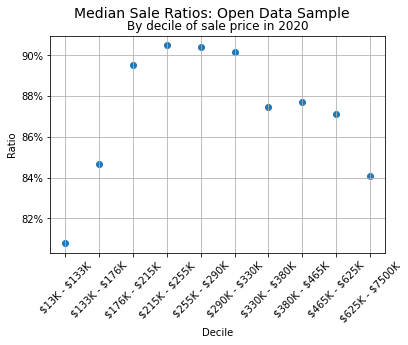

In [5]:
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

graph_data = combined
graph_data['rank'] = pd.qcut(graph_data['sale_price'], 10, labels=False)
graph_data['rank'] = graph_data['rank'] + 1
graph_data['decile'] = pd.qcut(graph_data['sale_price'] / 1000, 10, precision=0)
graph_data['decile'] = graph_data['decile'].astype(str).str.replace('(', '\$')
graph_data['decile'] = graph_data['decile'].str.replace(', ', ' - \$')
graph_data['decile'] = graph_data['decile'].str.replace('.0', 'K', regex=False)
graph_data['decile'] = graph_data['decile'].str.replace(']', '')
graph_data['decile'] = graph_data['decile'].str.replace(' - \$9050K', '+', regex=False)
graph_data = graph_data.groupby(['rank', 'decile']).apply(
        lambda x: pd.Series({
            'Median Sales Ratio':np.median(x['ratio']),
            })
        )

graph_data = graph_data.reset_index()
plt.scatter(graph_data['decile'], graph_data['Median Sales Ratio'])
plt.xticks(rotation=45)
plt.xlabel('Decile')
plt.ylabel('Ratio')
plt.suptitle("Median Sale Ratios: Open Data Sample", fontsize=14)
plt.title("By decile of sale price in 2020")
plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()])
plt.grid()
plt.show()

### Detecting selective appraisals

Selective appraisal, sometimes referred to as sales chasing, happens when a property is reappraised to shift its assessed value toward its actual sale price. The CCAO requires selective appraisal detection in every sales ratio study. This is because selective appraisal renders all other sales ratio statistics suspect. In the code below, we construct two sets of ratios, one normally distributed, and one 'chased.'

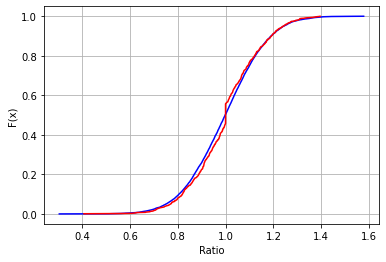

{'Blue Chased?': False, 'Red Chased?': True}

In [7]:
from statsmodels.distributions.empirical_distribution import ECDF

# Generate fake data with normal vs chased ratios
normal_ratios = np.random.normal(1, 0.15, 10000)
chased_ratios = list(np.random.normal(1, 0.15, 900)) + [1] * 100

# Plot to view discontinuity
ecdf_normal = ECDF(normal_ratios)
ecdf_chased = ECDF(chased_ratios)
plt.plot(ecdf_normal.x, ecdf_normal.y, color = 'blue')
plt.plot(ecdf_chased.x, ecdf_chased.y, color = 'red')
plt.xlabel('Ratio')
plt.ylabel('F(x)')
plt.grid()
plt.show()

{'Blue Chased?': ap.detect_chasing(normal_ratios), 'Red Chased?': ap.detect_chasing(chased_ratios)}

Ratios that include selective appraisals will be clustered around the value of one much more than ratios produced from a CAMA system. We can see this visually in the graph where the cumulative distribution curve shows a discontinuous jump, or 'flat spot', near one.